## Desafio:
**Objetivo:** Prever resultado de exame (normexam) e identificar tipo de escola mais eficiente.

## 1. Imports
O primeiro passo é a impotação das bibliotecas necessárias.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from io import StringIO
from sklearn.model_selection import GridSearchCV

## 2. Carregamento dos dados
Depois é necessário fazer o carregamento dos arquivos para um Dataframe

In [ ]:
try:
    cat_school = pd.read_csv('cat_school_data.csv', sep=';')
    num_school = pd.read_csv('num_school_data.csv', sep=';')
    cat_student = pd.read_csv('cat_student_data.csv', sep=';')
    num_student = pd.read_csv('num_student_data.csv', sep=';')
    print("\nDados carregados com sucesso!")
except FileNotFoundError:
    print("\nErro: Um ou mais arquivos CSV não foram encontrados. Certifique-se de que os arquivos estão na mesma pasta do notebook e os nomes correspondem.")
    exit()
except Exception as e:
    print(f"\nOcorreu um erro durante o carregamento: {e}")


Dados carregados com sucesso!


## 3. Pivotagem da tabela

Notei que os dados carregados inicialmente se encontravam no formato longo (empilhados), por isso, para facilitar a manipulação e, principalmente, para preparar os dados para a etapa de modelagem, realizei a transformação para o formato largo (pivotado).

In [ ]:
try:
    cat_student_wide = cat_student.pivot_table(index=['school', 'student'], columns='variable', values='value', aggfunc='first').reset_index()
    num_student_wide = num_student.pivot_table(index=['school', 'student'], columns='variable', values='value', aggfunc='first').reset_index()
    cat_school_wide = cat_school.pivot_table(index='school', columns='variable', values='value', aggfunc='first').reset_index()
    num_school_wide = num_school.pivot_table(index='school', columns='variable', values='value', aggfunc='first').reset_index()
    print("\nDados pivotados com sucesso!")
except Exception as e:
    print(f"\nOcorreu um erro durante a pivotagem: {e}")

cat_student_wide.drop_duplicates(inplace=True)
num_student_wide.drop_duplicates(inplace=True)
cat_school_wide.drop_duplicates(inplace=True)
num_school_wide.drop_duplicates(inplace=True)


Dados pivotados com sucesso!


## 4. Merge dos dados
Para facilitar a análise e modelagem dos dados era necessário realizar a junção de diferentes DataFrames, combinando informações de estudantes e escolas "dados_combinados_df".


In [ ]:
try:
    # Merge estudantes
    student_df = pd.merge(cat_student_wide, num_student_wide, on=['school', 'student'], how='inner')
    # Merge escolas
    school_df = pd.merge(cat_school_wide, num_school_wide, on='school', how='inner')
    # Merge final
    dados_combinados_df = pd.merge(student_df, school_df, on='school', how='inner')
    print("\nDados mergeados com sucesso!")
except Exception as e:
    print(f"\nOcorreu um erro durante o merge: {e}")


Dados mergeados com sucesso!


## 5. Tratamento dos dados

Para garantir a qualidade e usabilidade dos dados é necessário realizar o tratamento dos dados:

1. Remoção de linhas duplicadas
2. Transformações para os formatos corretos
3. Lidar com valores nulos
4. Lidar com outliers

### 5.1 Remoção de duplicatas
Realização da remoção das duplicatas

In [ ]:
dados_combinados_df.drop_duplicates(inplace=True)

### 5.2 Transformação de object -> float
Analisei o formato das colunas do Dataframe e notei que todas eram do tipo "object", então iniciei o tratamentos dos dados pelas colunas: normexam, standLRT e schavg que deveriam ser formato "float" já que são notas.

Os passos foram:
1. Remoção dos espaços em branco
2. Substituição da vírgula por ponto
3. Conversão para o tipo "float"

In [ ]:
# Tratamento da coluna 'normexam'
dados_combinados_df['normexam'] = dados_combinados_df['normexam'].str.strip()
dados_combinados_df['normexam'] = dados_combinados_df['normexam'].str.replace(',', '.', regex=False)
dados_combinados_df['normexam'] = pd.to_numeric(dados_combinados_df['normexam'], errors='coerce')

# Tratamento da coluna 'standLRT'
dados_combinados_df['standLRT'] = dados_combinados_df['standLRT'].str.strip()
dados_combinados_df['standLRT'] = dados_combinados_df['standLRT'].str.replace(',', '.', regex=False)
dados_combinados_df['standLRT'] = pd.to_numeric(dados_combinados_df['standLRT'], errors='coerce')

# Tratamento da coluna 'schavg'
dados_combinados_df['schavg'] = dados_combinados_df['schavg'].str.strip()
dados_combinados_df['schavg'] = dados_combinados_df['schavg'].str.replace(',', '.', regex=False)
dados_combinados_df['schavg'] = pd.to_numeric(dados_combinados_df['schavg'], errors='coerce')

### 5.3 Lidando com valores nulos
Percebi que haviam valores nulos no Dataframe e que era necessário um tratamento. Para cada coluna apliquei uma estratégia diferente:

print(df1.isnull().sum())

**intake:** 67;    **sex:** 95;    **vr:** 52;   **normexam:** 70;  **standLRT:** 29;

**normexam (target):** possuia aproximadamente 2% de valores nulos, como é uma porcentagem pequena e se tratava da target, decidi deletar as linhas com nulos;

**sex:** Decidi imputar os valores possíveis já que a coluna "schgend" era preenchida com "girls" ou "boys" ou "mixed". O restante dos valores nulos que não tinha como saber o gênero, busquei descobrir a proporção de "F" e "M" nas escolas mistas e imputar os valores aleatoriamente;

**intake e vr:** Decidi imputar os valores de acordo com a moda agrupados por "schgend";

**standLRT:** Decidi imputar os valores de acordo com a mediana agrupados por "schgend";


In [ ]:
# normexam
df1 = dados_combinados_df.dropna(axis=0, subset=['normexam']).copy()

# sex
# Imputa 'F' em 'sex' onde 'schgend' é 'girls' e 'sex' é nulo
df1.loc[df1['schgend'] == 'girls', 'sex'] = df1.loc[df1['schgend'] == 'girls', 'sex'].fillna('F')
# Imputa 'M' em 'sex' onde 'schgend' é 'boys' e 'sex' é nulo
df1.loc[df1['schgend'] == 'boys', 'sex'] = df1.loc[df1['schgend'] == 'boys', 'sex'].fillna('M')

# Identificar os índices onde 'schgend' é 'mixed' e 'sex' é nulo e imputa aleatoriamente o sexo
indices_nulos_mixed = df1.loc[(df1['schgend'] == 'mixed') & (df1['sex'].isnull())].index

# Contar o número de valores nulos a serem preenchidos
num_nulos_mixed = len(indices_nulos_mixed)

# Calcular a proporção atual de 'F' e 'M' em escolas mistas (não nulos)
proporcao_F = (df1.loc[df1['schgend'] == 'mixed', 'sex'] == 'F').mean()

# Determinar quantos 'F' e 'M' gerar para manter o balanceamento (aproximado)
num_F = int(round(num_nulos_mixed * proporcao_F))
num_M = num_nulos_mixed - num_F

# Criar a lista de valores a serem imputados
valores_aleatorios = ['F'] * num_F + ['M'] * num_M
np.random.shuffle(valores_aleatorios)

# Preencher os valores nulos com a amostra aleatória
df1.loc[indices_nulos_mixed, 'sex'] = valores_aleatorios


# intake e vr - moda por 'schgend'
df1['intake'] = df1.groupby('schgend')['intake'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None))
df1['vr'] = df1.groupby('schgend')['vr'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None))


# standLRT - mediana por 'schgend'
df1['standLRT'] = df1.groupby('schgend')['standLRT'].transform(lambda x: x.fillna(x.median()))

## 6. EDA - Análise Exploratória
Vamos investigar os dados

### 6.1 Distribuição de alunos por tipo de escola (schgend)
A maior parte dos alunos estão na escola do tipo "mixed" e a menor porção é de escolas de "boys";

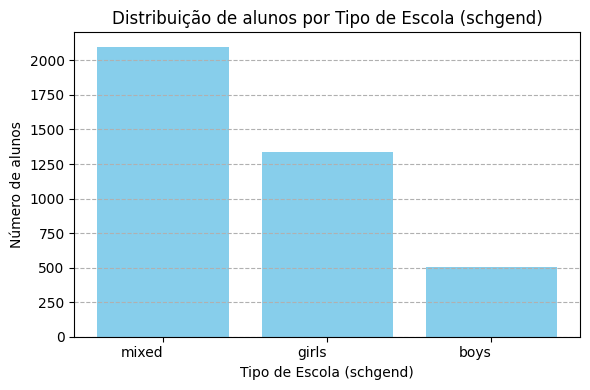

In [ ]:
contagem_por_tipo_escola = df1['schgend'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(contagem_por_tipo_escola.index, contagem_por_tipo_escola.values, color='skyblue')
plt.xlabel('Tipo de Escola (schgend)')
plt.ylabel('Número de alunos')
plt.title('Distribuição de alunos por Tipo de Escola (schgend)')
plt.xticks(contagem_por_tipo_escola.index, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### 6.2 Detectando outliers por fecture contínua
Uma etapa crucial da análise envolve a identificação de outliers. Ao investigar as colunas contínuas, constatei a presença de valores atípicos em "normexam" e "standLRT"

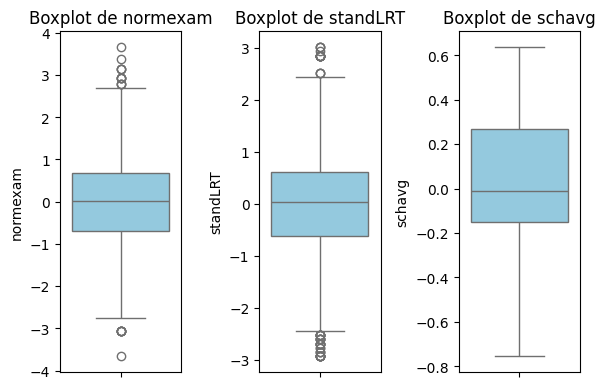

In [ ]:
plt.figure(figsize=(6, 4))
cor_padrao = 'skyblue'

plt.subplot(1, 3, 1)
sns.boxplot(y=df1['normexam'], color=cor_padrao)
plt.title('Boxplot de normexam')

plt.subplot(1, 3, 2)
sns.boxplot(y=df1['standLRT'], color=cor_padrao)
plt.title('Boxplot de standLRT')

plt.subplot(1, 3, 3)
sns.boxplot(y=df1['schavg'], color=cor_padrao)
plt.title('Boxplot de schavg')

plt.tight_layout()
plt.show()

### 6.3.1 Detectando a porcentagem de outliers em "normexam"
Dada a baixa proporção de outliers em "normexam" (0.47%) e sua representação de notas tanto maiores quanto menores, optei por não aplicar tratamento específico.

In [ ]:
Q1 = df1['normexam'].quantile(0.25)
Q3 = df1['normexam'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificando os outliers (criar a variável 'outliers')
outliers = (df1['normexam'] < limite_inferior) | (df1['normexam'] > limite_superior)

# Criando um novo DataFrame sem os outliers
df1_sem_outliers = df1[
    (df1['normexam'] >= limite_inferior) & (df1['normexam'] <= limite_superior)
]

# Contando o número de outliers
numero_de_outliers = outliers.sum()

# Calculando a porcentagem de outliers
total_observacoes = len(df1['normexam'])
porcentagem_de_outliers = (numero_de_outliers / total_observacoes) * 100

print(f"Porcentagem de outliers na coluna 'normexam': {porcentagem_de_outliers:.2f}%")

Porcentagem de outliers na coluna 'normexam': 0.48%


### 6.3.2 Detectando a porcentagem de outliers em "standLRT"
Dada a baixa proporção de outliers em "standLRT" (1.19%) e sua representação de notas tanto maiores quanto menores, optei por não aplicar tratamento específico.

In [ ]:
# Calculando os quartis e o IQR para a coluna 'standLRT'
Q1_standLRT = df1['standLRT'].quantile(0.25)
Q3_standLRT = df1['standLRT'].quantile(0.75)
IQR_standLRT = Q3_standLRT - Q1_standLRT

# Calculando os limites inferior e superior para identificar outliers
limite_inferior_standLRT = Q1_standLRT - 1.5 * IQR_standLRT
limite_superior_standLRT = Q3_standLRT + 1.5 * IQR_standLRT

# Identificando os outliers na coluna 'standLRT'
outliers_standLRT = (df1['standLRT'] < limite_inferior_standLRT) | (df1['standLRT'] > limite_superior_standLRT)

# Criando um novo DataFrame sem os outliers da coluna 'standLRT'
df1_sem_outliers_standLRT = df1[~outliers_standLRT]

# Contando o número de outliers na coluna 'standLRT'
numero_de_outliers_standLRT = outliers_standLRT.sum()

# Calculando a porcentagem de outliers na coluna 'standLRT'
total_observacoes_standLRT = len(df1['standLRT'])
porcentagem_de_outliers_standLRT = (numero_de_outliers_standLRT / total_observacoes_standLRT) * 100

print(f"Porcentagem de outliers na coluna 'standLRT': {porcentagem_de_outliers_standLRT:.2f}%")

Porcentagem de outliers na coluna 'standLRT': 1.19%


### 6.4 Distribuição do Resultado do Exame Normalizado por sexo (F ou M)
Ao analisar possíveis diferenças significativas em "normexam" por sexo ("F" e "M"), observei no gráfico uma pequena vantagem no desempenho médio das alunas, com uma dispersão similar entre os grupos. Um ponto interessante foi a identificação de outliers positivos nas notas femininas.

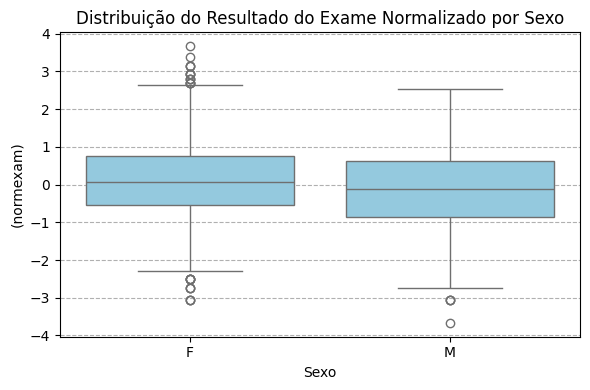

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='sex', y='normexam', data=df1, color='skyblue')
plt.title('Distribuição do Resultado do Exame Normalizado por Sexo')
plt.xlabel('Sexo')
plt.ylabel('(normexam)')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### 6.5 Desempenho no Exame Normalizado por Tipo de Escola (Gênero Único vs. Mistas)
Ao analisar possíveis diferenças significativas em "normexam" por type ("Genero único" e "Misto"), observei no gráfico uma pequena vantagem no desempenho médio dos alunos em escolas de gênero único em relação aos alunos de escolas mistas no exame normalizado.

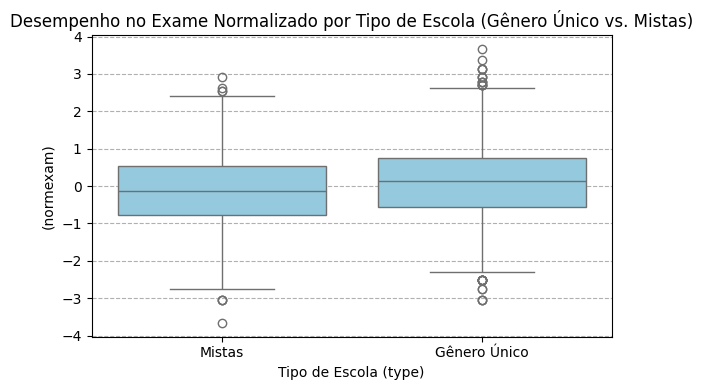

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='type', y='normexam', data=df1, color='skyblue')
plt.title('Desempenho no Exame Normalizado por Tipo de Escola (Gênero Único vs. Mistas)')
plt.xlabel('Tipo de Escola (type)')
plt.ylabel('(normexam)')
plt.xticks(ticks=['Sngl', 'Mxd'], labels=['Gênero Único', 'Mistas'])
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### 6.6 Distribuição do Resultado do Exame Normalizado por Tipo de Escola
Decidi verificar se havia alguma diferença significativa no 'normexam' entre os diferentes tipos de escola ('mixed', 'girls', 'boys'). Analisando o gráfico podemos perceber que as escolas só para garotas parecem ter uma ligeira vantagem no desempenho médio no exame normalizado (0.153830) em comparação com escolas mistas (-0.129085) e de garotos (0.019023). Além disso, a presença de mais outliers positivos em escolas de garotas sugere uma maior ocorrência de desempenhos excepcionalmente altos nesse tipo de escola.

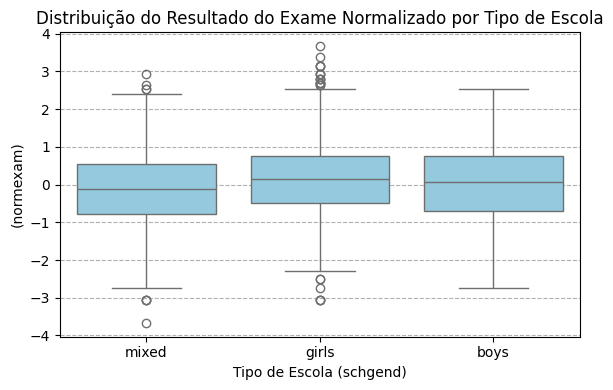

,count,mean,median,min,max,Q1,Q3,std
schgend,,,,,,,,
boys,503,0.019023,0.073536,-2.752660,2.532352,-0.699505,0.747228,1.053988
girls,1339,0.153830,0.134067,-3.059543,3.666091,-0.492781,0.747228,0.983829
mixed,2098,-0.097916,-0.129085,-3.666072,2.924667,-0.776109,0.544341,0.980680


In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='schgend', y='normexam', data=df1, color='skyblue')
plt.title('Distribuição do Resultado do Exame Normalizado por Tipo de Escola')
plt.xlabel('Tipo de Escola (schgend)')
plt.ylabel('(normexam)')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Calcular as estatísticas descritivas agrupadas por 'schgend'
summary_table = df1.groupby('schgend')['normexam'].agg(
    ['count', 'mean', 'median', 'min', 'max',
     lambda x: x.quantile(0.25),
     lambda x: x.quantile(0.75),
     'std']
).rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q3'})

display(summary_table)

## 7. Pré-processamento

Pra dar continuidade nas análises e chegar em conclusões, o pré-processamento dos dados era essencial, já que tínhamos tanto dados ordinais quanto não ordinais. Para cada tipo eu apliquei uma técnica diferente:

**Dados ordinais (intake e vr):** Para as colunas 'intake' e 'vr', onde a ordem das categorias é significativa, realizei a codificação ordinal manual. Preservei a ordem de importância.

**Dados não ordinais (sex, type, schgend):** Utilizei o LabelEncoder(). Como ele ordena em ordem alfabetica "sex" ficou: **{'boys': 0, 'girls': 1, 'mixed': 2}** ;



In [ ]:
# Mapeamento de valores categóricos
intake_mapping = {'bottom 25%': 0.25, 'mid 50%': 0.50, 'top 25%': 0.75}
df1['intake_encoded'] = df1['intake'].map(intake_mapping)
df1.drop(columns=['intake'], inplace=True)
df1.rename(columns={'intake_encoded': 'intake'}, inplace=True)

vr_mapping = {'bottom 25%': 0.25, 'mid 50%': 0.50, 'top 25%': 0.75}
df1['vr_encoded'] = df1['vr'].map(vr_mapping)
df1.drop(columns=['vr'], inplace=True)
df1.rename(columns={'vr_encoded': 'vr'}, inplace=True)


# Codificação de Rótulos
if 'sex' in df1.columns:
    le_sex = LabelEncoder()
    df1['sex'] = le_sex.fit_transform(df1['sex'])
# A ordem fica alfabética, portanto -> 0:boys; 1:girls; 2:mixed

if 'type' in df1.columns:
    le_type = LabelEncoder()
    df1['type'] = le_type.fit_transform(df1['type'])
# 'Mxd' -> 0 e 'Sngl' -> 1

if 'schgend' in df1.columns:
    le_schgend = LabelEncoder()
    df1['schgend'] = le_schgend.fit_transform(df1['schgend'])
# 'boys' -> 0 e 'girls' -> 1 e 'mixed' -> 2


## 8. Validando os resultados

### 8.1 Teste de Hipótese
Agora vamos fazer o Teste de Hipótese para investigar se a aparente vantagem no desempenho médio das alunas em escolas só para garotas (em relação a outros tipos de escola) é estatisticamente significativa.

**Conclusão da análise**:
A diferença é considerada estatisticamente significante porque o valor p (a probabilidade de observar os dados sob a hipótese nula) é menor que o nível de significância predefinido (geralmente 0.05), indicando que a probabilidade da diferença ocorrer por acaso é baixa, e a magnitude da estatística t (valor absoluto) sugere que a diferença entre as médias é considerável em relação à variabilidade dos dados.
Portanto, as notas médias (normexam) são significativamente diferentes entre cada par dos três tipos de escola (schgend). Isso indica fortemente que o tipo de escola influencia a nota dos alunos.

In [ ]:
# Separar os dados de 'normexam' para cada grupo de 'schgend'
grupo_0 = df1[df1['schgend'] == 0]['normexam']
grupo_1 = df1[df1['schgend'] == 1]['normexam']
grupo_2 = df1[df1['schgend'] == 2]['normexam']

# Realizar o teste t entre o grupo 0 e o grupo 1
t_statistic_01, p_value_01 = stats.ttest_ind(grupo_0, grupo_1, equal_var=False)
print(f"Teste t entre schgend=0 e schgend=1:")
print(f"  Estatística t: {t_statistic_01:.4f}")
print(f"  Valor p: {p_value_01:.4f}")
alpha = 0.05  # Nível de significância
if p_value_01 < alpha:
    print("  Rejeitamos a hipótese nula: Há diferença significativa nas médias.")
else:
    print("  Não rejeitamos a hipótese nula: Não há evidências de diferença significativa.")
print("-" * 30)

# Realizar o teste t entre o grupo 0 e o grupo 2
t_statistic_02, p_value_02 = stats.ttest_ind(grupo_0, grupo_2, equal_var=False)
print(f"Teste t entre schgend=0 e schgend=2:")
print(f"  Estatística t: {t_statistic_02:.4f}")
print(f"  Valor p: {p_value_02:.4f}")
if p_value_02 < alpha:
    print("  Rejeitamos a hipótese nula: Há diferença significativa nas médias.")
else:
    print("  Não rejeitamos a hipótese nula: Não há evidências de diferença significativa.")
print("-" * 30)

# Realizar o teste t entre o grupo 1 e o grupo 2
t_statistic_12, p_value_12 = stats.ttest_ind(grupo_1, grupo_2, equal_var=False)
print(f"Teste t entre schgend=1 e schgend=2:")
print(f"  Estatística t: {t_statistic_12:.4f}")
print(f"  Valor p: {p_value_12:.4f}")
if p_value_12 < alpha:
    print("  Rejeitamos a hipótese nula: Há diferença significativa nas médias.")
else:
    print("  Não rejeitamos a hipótese nula: Não há evidências de diferença significativa.")

Teste t entre schgend=0 e schgend=1:
  Estatística t: -2.4899
  Valor p: 0.0130
  Rejeitamos a hipótese nula: Há diferença significativa nas médias.
------------------------------
Teste t entre schgend=0 e schgend=2:
  Estatística t: 2.2644
  Valor p: 0.0238
  Rejeitamos a hipótese nula: Há diferença significativa nas médias.
------------------------------
Teste t entre schgend=1 e schgend=2:
  Estatística t: 7.3247
  Valor p: 0.0000
  Rejeitamos a hipótese nula: Há diferença significativa nas médias.


### 8.2 Teste de Tukey
Agora vamos fazer o teste de Tukey. Ele é usado para fazer comparações pairwise (par a par) entre as médias dos grupos e determinar quais pares são significativamente diferentes.
Como todas as linhas do reject são True, podemos concluir que todos os grupos são significativamente diferentes em termos de desempenho médio.

In [ ]:
tukey_result = pairwise_tukeyhsd(df1['normexam'], df1['schgend'], alpha=0.05)

print("\nTeste Post-Hoc de Tukey para normexam por Tipo de Escola (schgend):")
print(tukey_result)


Teste Post-Hoc de Tukey para normexam por Tipo de Escola (schgend):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.1348 0.0253  0.0132  0.2564   True
     0      2  -0.1169 0.0462 -0.2323 -0.0015   True
     1      2  -0.2517    0.0  -0.333 -0.1704   True
----------------------------------------------------


## 9. TREINAMENTO

### 9.1 Correlação das fectures com o target (normexam)

Antes de realizar o treinamento é importante descobrir quais são as fectures mais importantes para o nosso target, por isso fiz a análise de correlação em relação à "normexam".

Como conclusão, é possivel ver que standLRT, intake, schavg e vr são as fectures mais correlacionadas com as notas do exame, portanto são as fectures mais importantes para predizer o target (normexam);

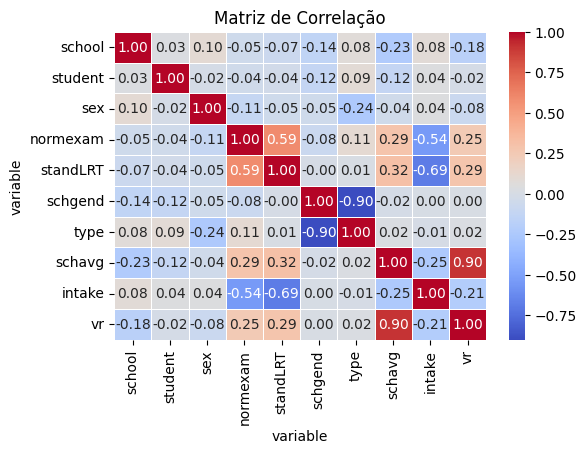


Correlação com 'normexam':
variable
normexam    1.000000
standLRT    0.588592
schavg      0.288480
vr          0.249214
type        0.107493
student    -0.042200
school     -0.054467
schgend    -0.079122
sex        -0.110804
intake     -0.538878
Name: normexam, dtype: float64


In [ ]:
correlation_matrix = df1.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

print("\nCorrelação com 'normexam':")
print(correlation_matrix['normexam'].sort_values(ascending=False))

## 9.2 Modelo

Dividi dataset em treino (80%) e teste (20%). Optei por uma proporção de teste maior que o usual (70%-30%) devido à quantidade limitada de dados para treinamento, buscando garantir que o modelo tivesse uma amostra razoável para aprendizado.

Para assegurar uma representação equilibrada dos tipos de escola (schgend), a divisão entre treino e teste manteve a mesma distribuição dessa variável. Isso visou evitar que um tipo de escola fosse predominantemente alocado em apenas uma das porções dos dados.

Inicialmente, avaliei três algoritmos de regressão: RandomForestRegressor, LinearRegression e GradientBoostingRegressor. O GradientBoostingRegressor se destacou com o melhor desempenho, o que levou à decisão de prosseguir a análise focando nesse modelo.

Posteriormente, para otimizar o desempenho do GradientBoostingRegressor, utilizei o GridSearchCV na busca pelos seus melhores hiperparâmetros. No notebook abaixo, o modelo já esta com os melhores hiperparâmetos.

**Os resultados obtidos, infelizmente, não atingiram o nível de satisfação desejado. Apesar de buscar reduzir os erros do modelo, como evidenciado pelo Mean Absolute Error (MAE) de 0.5665, Mean Squared Error (MSE) de 0.5294 e Root Mean Squared Error (RMSE) de 0.7276, mantendo sua capacidade de acerto (R-squared de 0.4662), o desempenho geral ainda não é considerado ideal.**



In [ ]:
# 1. Definir Features (X) e Target (y)
target = 'normexam'
features = [col for col in df1.columns if col != target and col != 'student' and col != 'variable' and col != 'school']

X = df1[features]
y = df1[target]

# 2. Dividir os Dados em Conjunto de Treinamento e Conjunto de Teste, estratificando por 'schgend'
X_train, X_test, y_train, y_test, schgend_train, schgend_test = train_test_split(
    X, y, df1['schgend'], test_size=0.2, random_state=42, stratify=df1['schgend']
)

# 3. Definir os Hiperparâmetros
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42, subsample=0.9, min_samples_split=2)
gbr.fit(X_train, y_train)

# 4. Fazer Previsões no Conjunto de Teste
y_pred = gbr.predict(X_test)

# 5. Avaliar o Desempenho do Modelo
mae = mean_absolute_error(y_test, y_pred)
print(f'\nMean Absolute Error (MAE): {mae:.4f}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2:.4f}')

# 6. Analisar a Importância das Features no Gradient Boosting
feature_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
print("\nImportância das Features (Gradient Boosting):")
print(feature_importances.sort_values(ascending=False))


Mean Absolute Error (MAE): 0.5668
Mean Squared Error (MSE): 0.5298
Root Mean Squared Error (RMSE): 0.7278
R-squared (R²): 0.4659

Importância das Features (Gradient Boosting):
variable
standLRT    0.532834
intake      0.246704
schavg      0.181616
sex         0.015618
schgend     0.013307
type        0.008003
vr          0.001919
dtype: float64


### 9.3 GridSearchCV na busca pelos seus melhores hiperparâmetros

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.03],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'subsample': [0.8, 0.9],
    'max_features': ['sqrt', None]
}

# Criando uma instância do GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)

# Executando a busca nos seus dados de treinamento
grid_search.fit(X_train, y_train)

# Obtendo os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print(f'Melhores Hiperparâmetros: {best_params}')

# Obtendo melhor modelo treinado
best_gbr_model = grid_search.best_estimator_

# Avaliando o melhor modelo no conjunto de teste
y_pred_best = best_gbr_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
print(f'R² do Melhor Modelo Gradient Boosting: {r2_best:.4f}')

Melhores Hiperparâmetros: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
R² do Melhor Modelo Gradient Boosting: 0.4618


### 9.4 Gráfico de Dispersão das Previsões vs. Valores Reais

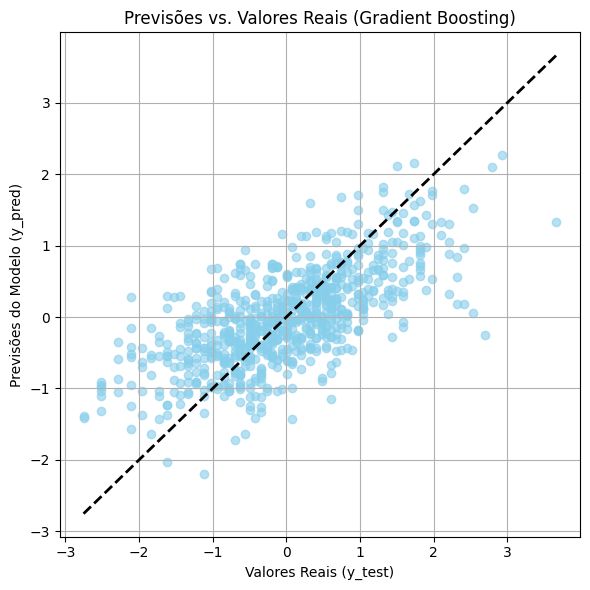

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='skyblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Linha de referência para previsões perfeitas
plt.xlabel('Valores Reais (y_test)')
plt.ylabel('Previsões do Modelo (y_pred)')
plt.title('Previsões vs. Valores Reais (Gradient Boosting)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Próximos passos:

    1. Coletar mais dados: Se possível, aumentar o tamanho do conjunto de treinamento pode melhorar o desempenho do modelo.
    2. Engenharia de features: Criar novas features a partir das existentes ou incorporar informações externas pode ajudar o modelo a capturar mais padrões.
    3. Testar outros modelos

## 11. CONCLUSÃO

A análise mostrou que o tipo de escola ("schgend") influencia o desempenho no "normexam", com as escolas só de meninas tendo uma média ligeiramente maior e diferenças significativas confirmadas pelo Teste de Tukey entre todos os tipos. Isso sugere que o ambiente escolar (gênero único ou misto) está ligado a diferentes resultados médios, mesmo que a diferença não seja enorme. Além disso, "schavg", "standLRT" e "intake" são variáveis importantes para prever o sucesso no "normexam" e devem ser usadas para o modelo preditivo.